In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install visualkeras
import visualkeras
import keras
from glob import glob
from tqdm import tqdm
import cv2
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,BatchNormalization,Input,Flatten,Dropout,GlobalMaxPooling2D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 37.6 MB/s 


In [3]:
df=pd.DataFrame()
label=0
# image_data=[]
# labels=[]
for category in glob('/content/drive/MyDrive/Garbage_Detection/garbage_classification/*'):
    for files in tqdm(glob(category+'/*')):
        image=cv2.imread(files)
        image=cv2.resize(image,(224,224))    #As images are of different shape so resizing all to (224,224,3)
        data=pd.DataFrame({'image':[image],'label':[label]})
        df=df.append(data)
    label+=1

100%|██████████| 1626/1626 [00:22<00:00, 73.31it/s] 


In [4]:
celltext=[]
transform_classes={}
label=0
for name in glob('/content/drive/MyDrive/Garbage_Detection/garbage_classification/*'):
    names=[]
    names.append(name.split('/')[-1].upper().replace('_',' '))
    names.append(label)
    celltext.append(names)
    transform_classes[label]=name.split('/')[-1]
    label+=1

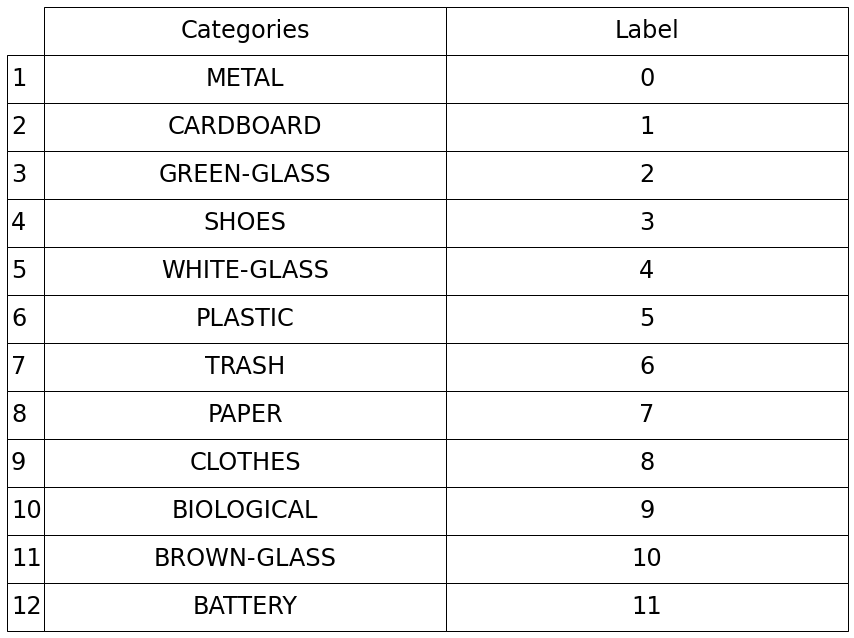

In [5]:
plt.axis('off')
plt.axis('tight')
column_names=['Categories','Label']
row_names=[x for x in range(1,13)]
plot=plt.table(cellText=celltext,cellLoc='center',
               rowLabels=row_names,colWidths=[1.2]*10,colLabels=column_names,loc='center')
plot.set_fontsize(24)
plot.scale(1, 4)

SHUFFLING DATASET

In [6]:
df=df.sample(frac=1).reset_index(drop=True)

In [7]:
df.head()

,image,label
0,"[[[164, 170, 207], [164, 170, 207], [169, 175,...",8
1,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",4
2,"[[[233, 232, 234], [233, 232, 234], [233, 232,...",6
3,"[[[48, 48, 48], [62, 62, 62], [86, 86, 86], [8...",11
4,"[[[165, 165, 165], [166, 166, 166], [166, 166,...",6


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19512 entries, 0 to 19511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   19512 non-null  object
 1   label   19512 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 305.0+ KB


IMAGE SHAPE

In [9]:
df.image.iloc[1].shape

(224, 224, 3)

In [10]:
from sklearn.model_selection import train_test_split
train_image,test_image,train_label,test_label=train_test_split(df.image,df.label,test_size=0.1,random_state=42)

DELETING THE DATAFRAMES WHICH ARE NOT IN USE TO FREE RAM

In [11]:
del df
del data

VISUALIZE DATASET

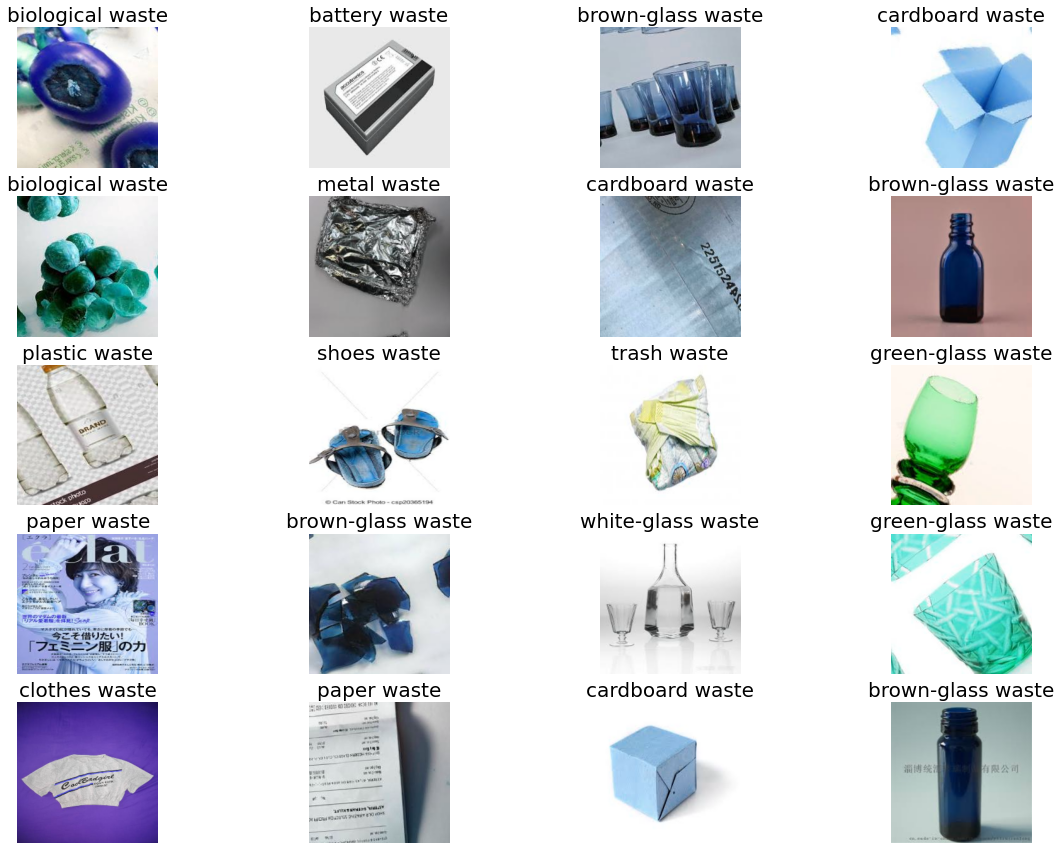

In [12]:
plt.figure(figsize=(20,15))
for i in range(22):
    plt.subplot(5,4,(i%20)+1)
    rand_idx=np.random.randint(1000)
    plt.title('{0} waste'.format(transform_classes[train_label.iloc[rand_idx]]),fontdict={'size':20})
    plt.axis('off')
    plt.imshow(train_image.iloc[rand_idx])
#     plt.tight_layout()
plt.show()

In [13]:
def change_to_input_dimension(data):
    data=np.reshape(data.to_list(),(len(data),224,224,3))
    return data
train_image=change_to_input_dimension(train_image)
test_image=change_to_input_dimension(test_image)

CALLBACKS FUNCTION

In [14]:
early_stop=EarlyStopping(monitor='val_loss',patience=4)
reduceLR=ReduceLROnPlateau(patience=3)

BUILDING MODEL

In [15]:
model=Sequential()
model.add(Input(shape=(224,224,3)))
model.add(Conv2D(256,(3,3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(GlobalMaxPooling2D())
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(12,activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [16]:
r=model.fit(train_image,train_label,validation_data=(test_image,test_label),epochs=50,callbacks=[early_stop,reduceLR])

Epoch 1/50
549/549 [==============================] - 137s 217ms/step - loss: 1.8734 - accuracy: 0.3841 - val_loss: 1.6199 - val_accuracy: 0.4559 - lr: 0.0010
Epoch 2/50
549/549 [==============================] - 119s 218ms/step - loss: 1.5835 - accuracy: 0.4829 - val_loss: 1.6219 - val_accuracy: 0.4606 - lr: 0.0010
Epoch 3/50
549/549 [==============================] - 119s 217ms/step - loss: 1.4574 - accuracy: 0.5226 - val_loss: 1.6444 - val_accuracy: 0.4641 - lr: 0.0010
Epoch 4/50
549/549 [==============================] - 119s 217ms/step - loss: 1.3774 - accuracy: 0.5512 - val_loss: 1.4358 - val_accuracy: 0.5456 - lr: 0.0010
Epoch 5/50
549/549 [==============================] - 119s 217ms/step - loss: 1.3030 - accuracy: 0.5740 - val_loss: 1.5200 - val_accuracy: 0.5056 - lr: 0.0010
Epoch 6/50
549/549 [==============================] - 119s 217ms/step - loss: 1.2478 - accuracy: 0.5944 - val_loss: 1.1729 - val_accuracy: 0.5973 - lr: 0.0010
Epoch 7/50
549/549 [==========================

In [17]:
model.save('/content/drive/MyDrive/Garbage_Detection/final_model.h5')

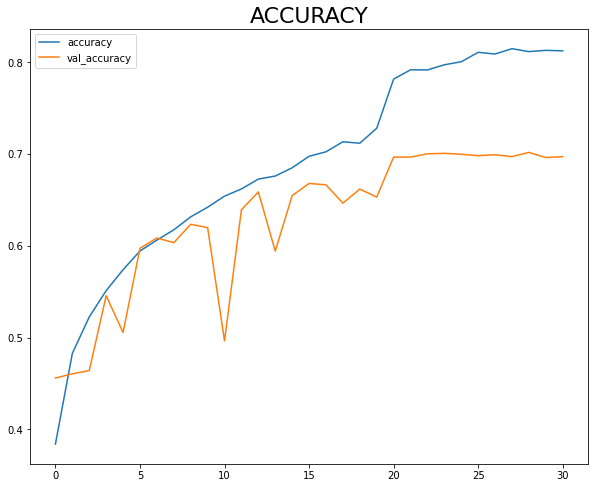

In [18]:
plt.figure(figsize=(10,8))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.title('ACCURACY',fontdict={'size':22})
plt.show()

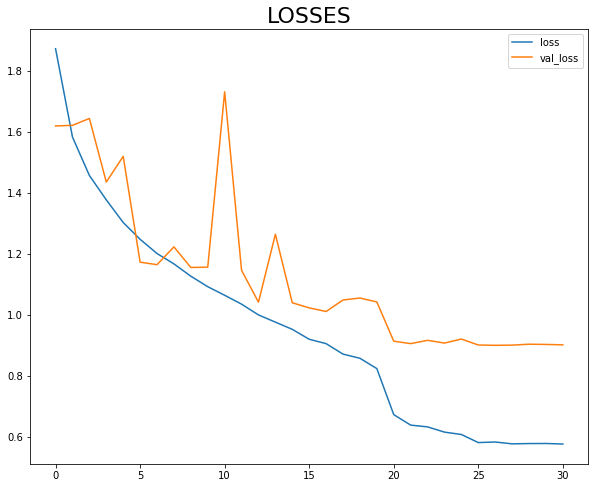

In [19]:
plt.figure(figsize=(10,8))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('LOSSES',fontdict={'size':22})
plt.show()